## Notebook 02a: Understanding the sub-sevir Deep Learning Classification and Regression Models using SHAP


<div class="alert alert-block alert-danger"><b>Warning: </b> Before running this notebook, run the download_deep.ipynb notebook. That notebook will download the data and models used in this notebook. </div>


### Goal: Interogate the pre-trained classification and regression CNN models using SHAP

#### Background

In a [previous notebook](https://github.com/ai2es/tai4es-trustathon-2022/blob/main/severe/notebooks/Notebook_01a_ClassificationExplainability.ipynb), we interogated traditional ML models trained on manually engineered features from the sub-SEVIR dataset. We determined the top features, the relationships learned, and even explored explainability for individual predictions. For example, we found that spatial-maximum VIL and spatial-minimum IR temperature were the top features and the learned relationships matched with our physical intuition. In this notebook, we will try and understand convolutional neural networks that were trained on the identical tasks as the traditional ML models:
1. Does the image contain a lightning flash? 
2. How many lightning flashes are occuring in this image? 

The machine learning models here are trained as part of a paper that is in prep for WAF (Chase et al. "A Machine Learning Tutorial for Operational Meteorology, Part II: Neural Networks"). To be explicit, we assume the GOES Lightning Mapper (GLM) observations are unavailable and we need to use the other measurements (e.g., infrared brightness temperature) as features to estimate if there are lightning flashes (i.e., classification), and how many of them are there (i.e., regression).

These are the same tasks as [Chase et al. (2022)](https://arxiv.org/abs/2204.07492), so see that paper if you want perspective. We also discussed these ideas on slide 33 - 37 in the Day 2 slides. 



### Primary Task: 
1. Determine the important features
2. Use SHAP to explain the deep learning model 

In this notebook, you'll notice color-coded boxes, which may provide optional tasks, questions to discuss, or warnings. Here is the color-coding breakdown: 
* <span style="color:blue">Blue Box</span> = Question to discuss
* <span style="color:red">Red Box</span> = Warning/Caution
* <span style="color:gold">Yellow Box</span> = Optional task to perform 
* <span style="color:green">Green Box</span> = Useful Tip or Reminder


### Authors
* Randy Chase (OU/AI2ES) [email: randychase 'at' ou.edu; twitter: @dopplerchase]
* Montgomery Flora (CIWRO/NSSL) [email: monte.flora 'at' noaa.gov; twitter: @MontePhD]

### Import the neccesary third-party packages

In [1]:
#load model 
import tensorflow as tf 
import xarray as xr 
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
import shap
import cmocean

tf.compat.v1.disable_v2_behavior()

# Add ../scripts to our path so we can import functions from there.
import sys,os
sys.path.append('../scripts') 
from deep_util import get_group_idx, get_groups, show_sample, make_plot,standardanom
from plotting_config import deep_display_feature_names, deep_color_dict
from deep_perm_imp import ImagePermI


from custom_metrics import *

#log the metrics so tensorflow can find them 
custom_objects = {'ConditionalMeanAbsoluteError': ConditionalMeanAbsoluteError,
                    'ConditionalMeanError': ConditionalMeanError,
                    'ConditionalRootMeanSquaredError':ConditionalRootMeanSquaredError,
                    'MeanError': MeanError,
                    'MaxCriticalSuccessIndex':MaxCriticalSuccessIndex}

Instructions for updating:
non-resource variables are not supported in the long term


### Load the data.

The data has been pre-split into training, validation, and testing datasets. We will load in the `sub-SEVIR` dataset here and plot an example image. The example image is a strong convective event with plenty of lightning.

divide by zero encountered in log10


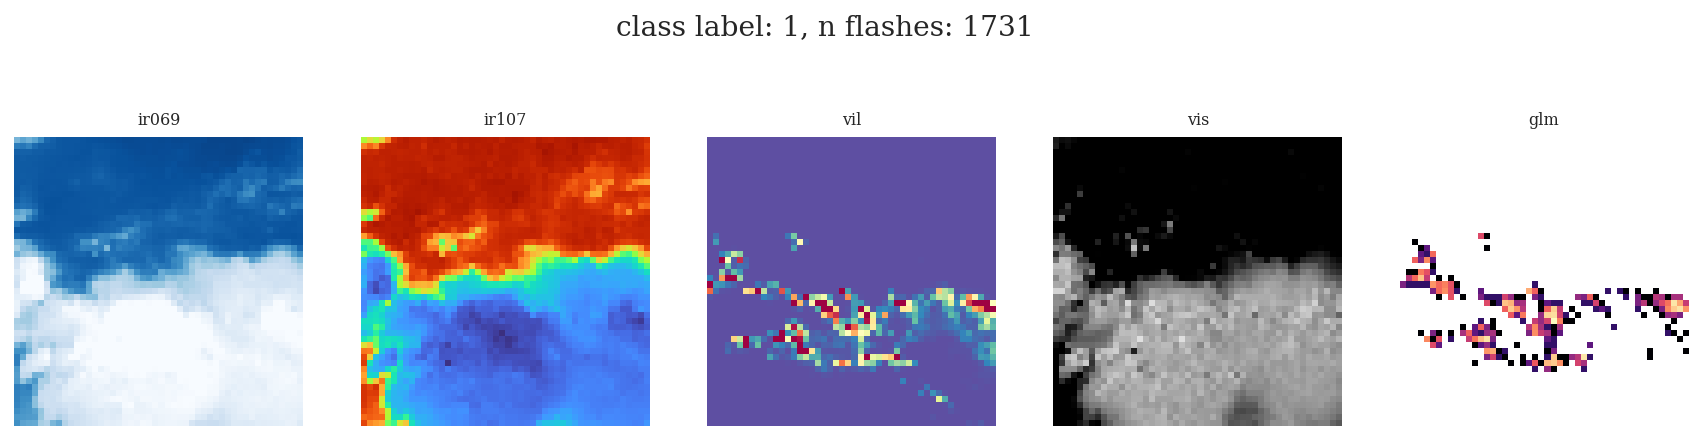

In [32]:
%config InlineBackend.figure_format = 'retina'

ds_train = xr.open_dataset('../datasets/sub-sevir-train.zarr', engine='zarr')
ds_val = xr.open_dataset('../datasets/sub-sevir-val.zarr', engine='zarr')
ds_test = xr.open_dataset('../datasets/sub-sevir-test.zarr', engine='zarr')

#choose 1 'storm' to show in examples
ds_sample = ds_val.isel(n_samples=ds_val.groupby('id').groups['S841009'])

#plot this example with a plotter function I have defined 
show_sample(ds_sample.isel(n_samples=11))

#store this image to do the XAI on 
im = ds_sample.isel(n_samples=11).features.values 

### Load the DL models.

Now that we have some data, let's load in the pretrained CNNs.

In [3]:
#classification model 
model_class = tf.keras.models.load_model('../models/sub-sevir-cnn-class-1d.h5',
                                                 custom_objects=custom_objects)

#need to remove sigmoid so XAI can see raw values 
model_class.layers[-1].activation = tf.keras.activations.linear

#regression model 
model_reg = tf.keras.models.load_model('../models/sub-sevir-cnn-reg-1d.h5',
                                                 custom_objects=custom_objects)

Instructions for updating:
Colocations handled automatically by placer.


2022-06-23 16:36:39.388372: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Task 1. Analyze the Important Features 

An initial task for understanding an ML model is understanding the important features – those features that contribute most to the model's performance. If the model performs well on independent data, then these features might provide insight into the data-generating process. The common approach for assessing feature importance is the permutation importance method. There are different flavors of permutation importance, which were covered in the lecture series. For this tutorial, we will only use the backward singlepass. 

In [4]:
X = ds_train.features.astype('float16').values[:,:,:,:]
y = ds_train.label_1d_class.astype('float16').values

# We are only using 75% of the training images to determine importance. 
# It is not neccesary to use the full training dataset since 
# we are generating bulk statistics. 
subsample_size=0.75

ip = ImagePermI(X, model_class, y, subsample_size=subsample_size)
ip.single_pass(direction='backward', metric='auc')

Shuffling Images, please wait...
done


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:39<00:00,  9.98s/it]


Though we cannot compute permutation importance for deep learning models using skexplain, 
we can leverage built-in function that allows us to use the plotting functionality. The `to_skexplain_importance` function is designed to take any importance/relevance scores, rank them from high to low, and then convert it into a skexplain-friendly data format. 


In [5]:
import skexplain
from skexplain.common.importance_utils import to_skexplain_importance

# Since we are ranking from high to low, we need to convert the 
# permuted scores into importance scores
imp_scores = ip.start_score - ip.scores

# We set the method as 'backward_singlepass'. This is an expected name in skexplain and will
# help with the plotting. 

# to_skexplain_importance is expecting the data in 
# following shape (n_features, n_permutes). For this notebook, 
# we only performed one permutation so we need to convert imp scores to (n_features, 1)
results = to_skexplain_importance(
    importances=np.array([imp_scores]).T, 
    estimator_name='CNN', 
    feature_names=ds_train.n_channel.values,
    method='backward_singlepass', normalize=False
)

# Since we are using backward permutation importance we will want to include the
# original score which is used for comparison to measure importance. 
results['original_score__CNN'] = (('n_boot'), [ip.start_score])

# Lastly, it is easier to interpret the feature importances if we convert back to the permuted scores.
results['backward_singlepass_scores__CNN'] =  ip.start_score - results['backward_singlepass_scores__CNN']

(<Figure size 900x750 with 3 Axes>, <AxesSubplot:xlabel='AUC'>)

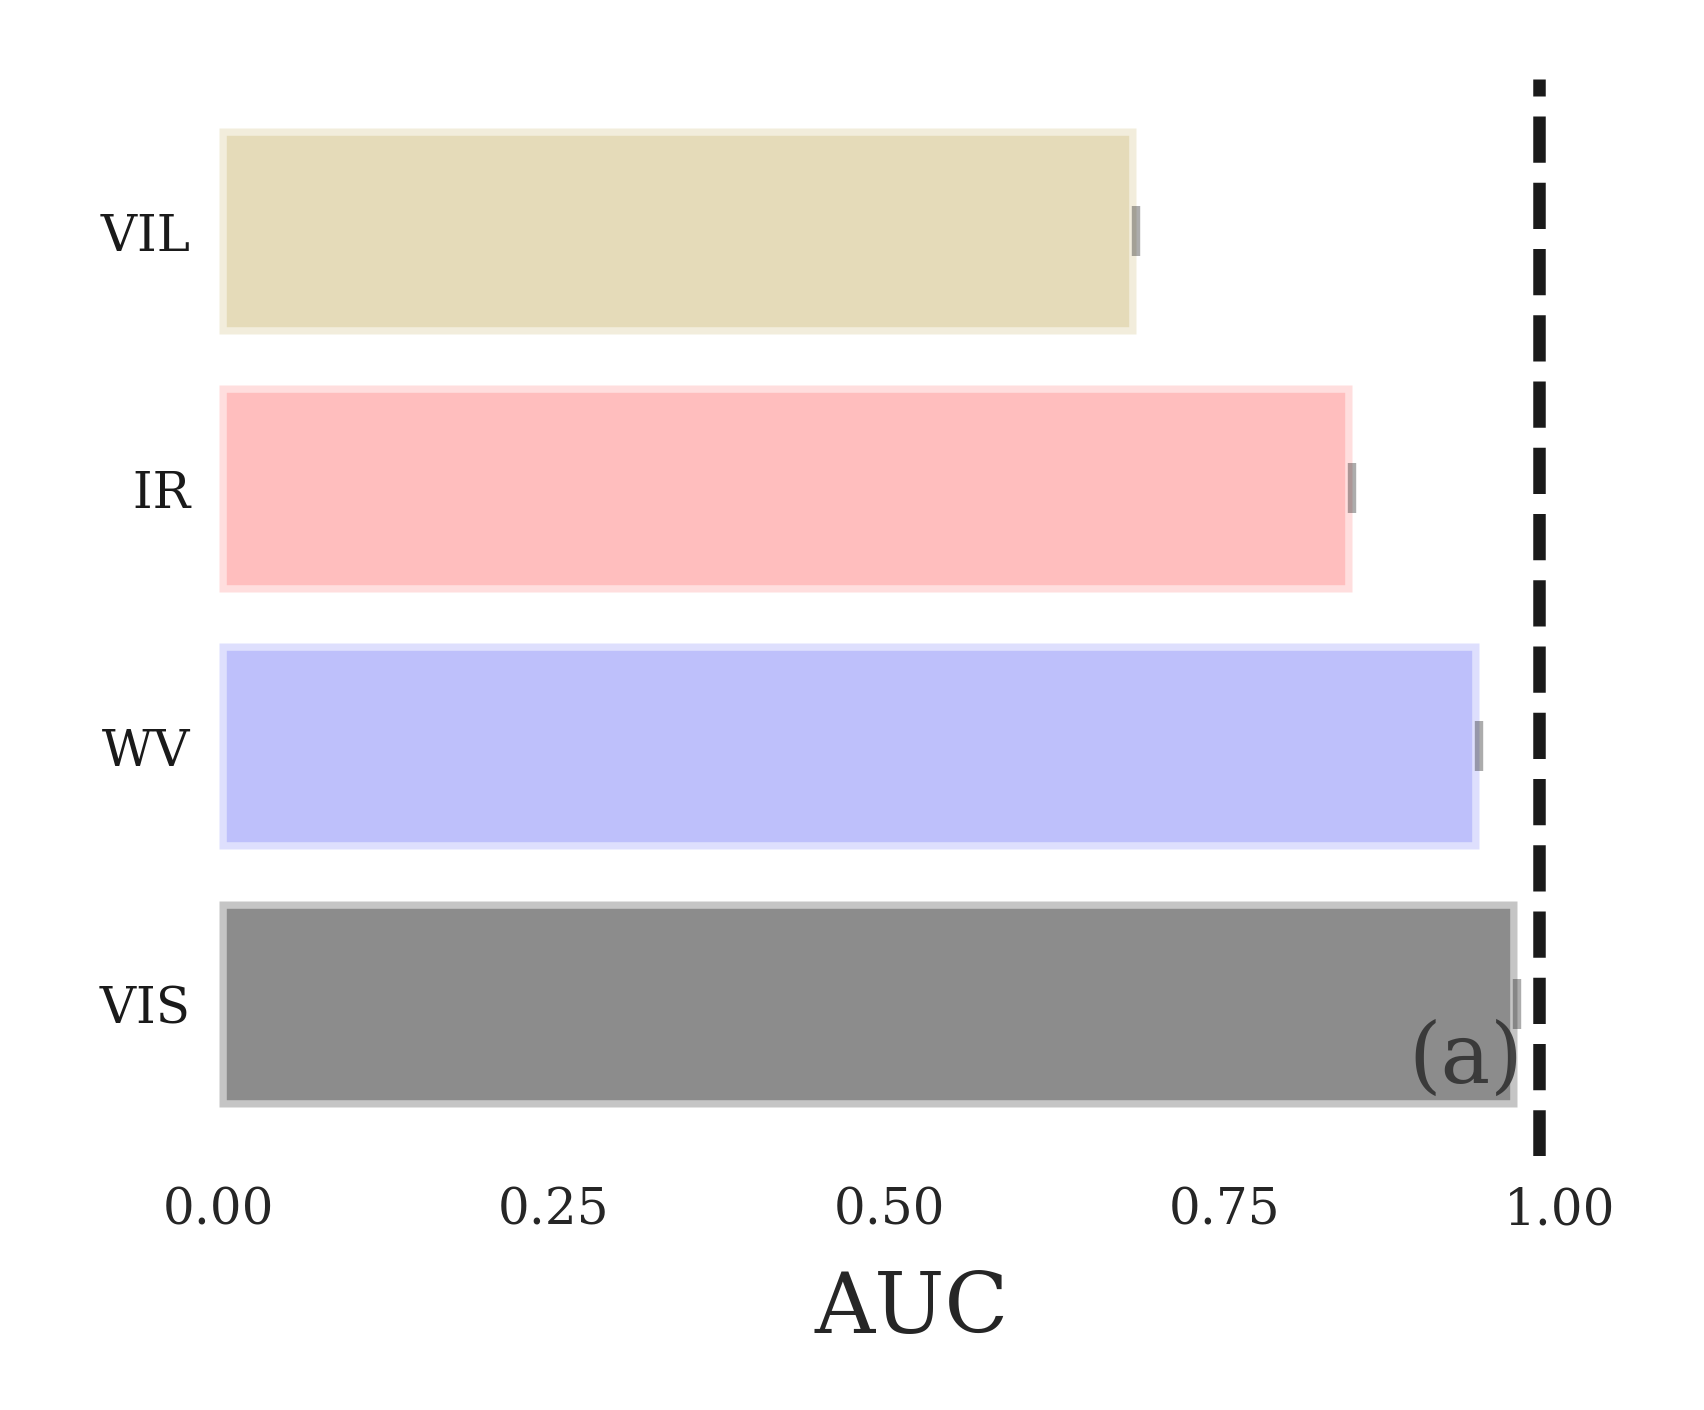

In [6]:
explainer = skexplain.ExplainToolkit()
explainer.plot_importance(results, panels = [('backward_singlepass', 'CNN')], 
                          xlabels=['AUC'], 
                          display_feature_names=deep_display_feature_names,
                          feature_colors=deep_color_dict)

The color coding is as follows: 
1. Red : Infrared (IR) brightness temperature-based features
2. Purple: Water vapor (WV) brightness temperature-based features
3. Gold: Vertically integrated liquid (VIL)-based features
    
<div class="alert alert-block alert-success"><b>Reminder about interpreting importance: </b> Permutation importance, whether backward or forward, is measure with respect to an original score. We measure importance with respect to original model performance for the backward method and with respect to all features being permuted for the forward method. For example, when permuted VIL has the greatest deviation from the original score and is thus the most important. </div>
  
For the classification CNN, the top feature was VIL, which is consistent with the traditional ML models. VIL and IR are plausible top features as high VIL values are associated with convective cores as are cold IR temperatures due to overshooting storm tops. 

## Task 2. Using SHAP to understand individual images

### Select background and initialize the SHAP explainer

SHAP needs training examples to learn the shap values from. To do this, we will give the shap python package 100 randomly sampled examples from the training dataset

In [29]:
#select a set of background examples to take an expectation over
background = ds_train.isel(n_samples=np.random.randint(0,ds_train.n_samples.shape[0],size=100))
background = background.features.values

# explain predictions of the model on four images
class_explainer = shap.DeepExplainer(model_class, background)
reg_explainer = shap.DeepExplainer(model_reg, background)

### Strong Convection Example

#### i. Classification
Below the shap values for the classification model for the deep convective event we chose. This is a confident prediction from the model, with an output probability of effectively 1 (i.e., 100% confident there is lightning in the image)

In [118]:
def make_plot(image,mask=None,maskalpha=0.7,title=r'Abs(SHAP Values) $\geq$ 0.001',
              cmap=cmocean.cm.balance,normalize=False):

    fig,axes = plt.subplots(nrows=2,ncols=2, figsize=(12,12))
    fig.set_facecolor('w')

    titles = ['WV','IR','VIL','VIS']
    vmins = [-2.5,-2.5,0,0]
    vmaxs = [2,2,20,4]

    cmaps = ['Blues','turbo','Spectral_r','Greys_r']
    
    vmin = np.min(mask)
    vmax = np.max(mask)
    
    mask = np.ma.masked_where(np.abs(mask)<=0.001, mask)
    
    for i,ax in enumerate(axes.flat):
        if i == 2:
            im = np.ma.masked_where(image[:,:,i] <= 0, image[:,:,i])
            alpha=0.9
        else:
            im = image[:,:,i]
            alpha=0.5
        ax.imshow(im,cmap=cmaps[i],vmin=vmins[i],vmax=vmaxs[i], alpha=alpha, aspect='auto')
        ax.pcolormesh(mask[:,:,i], cmap='seismic', alpha=0.9)# vmin=vmin, vmax=vmax, )
        
        ax.axis('off')
        ax.set_title(titles[i], fontsize=15)

    #axes_middle = axes[1,:]
    
    if title is not None:
        fig.suptitle(title,y=1)
    plt.tight_layout()

    return ax

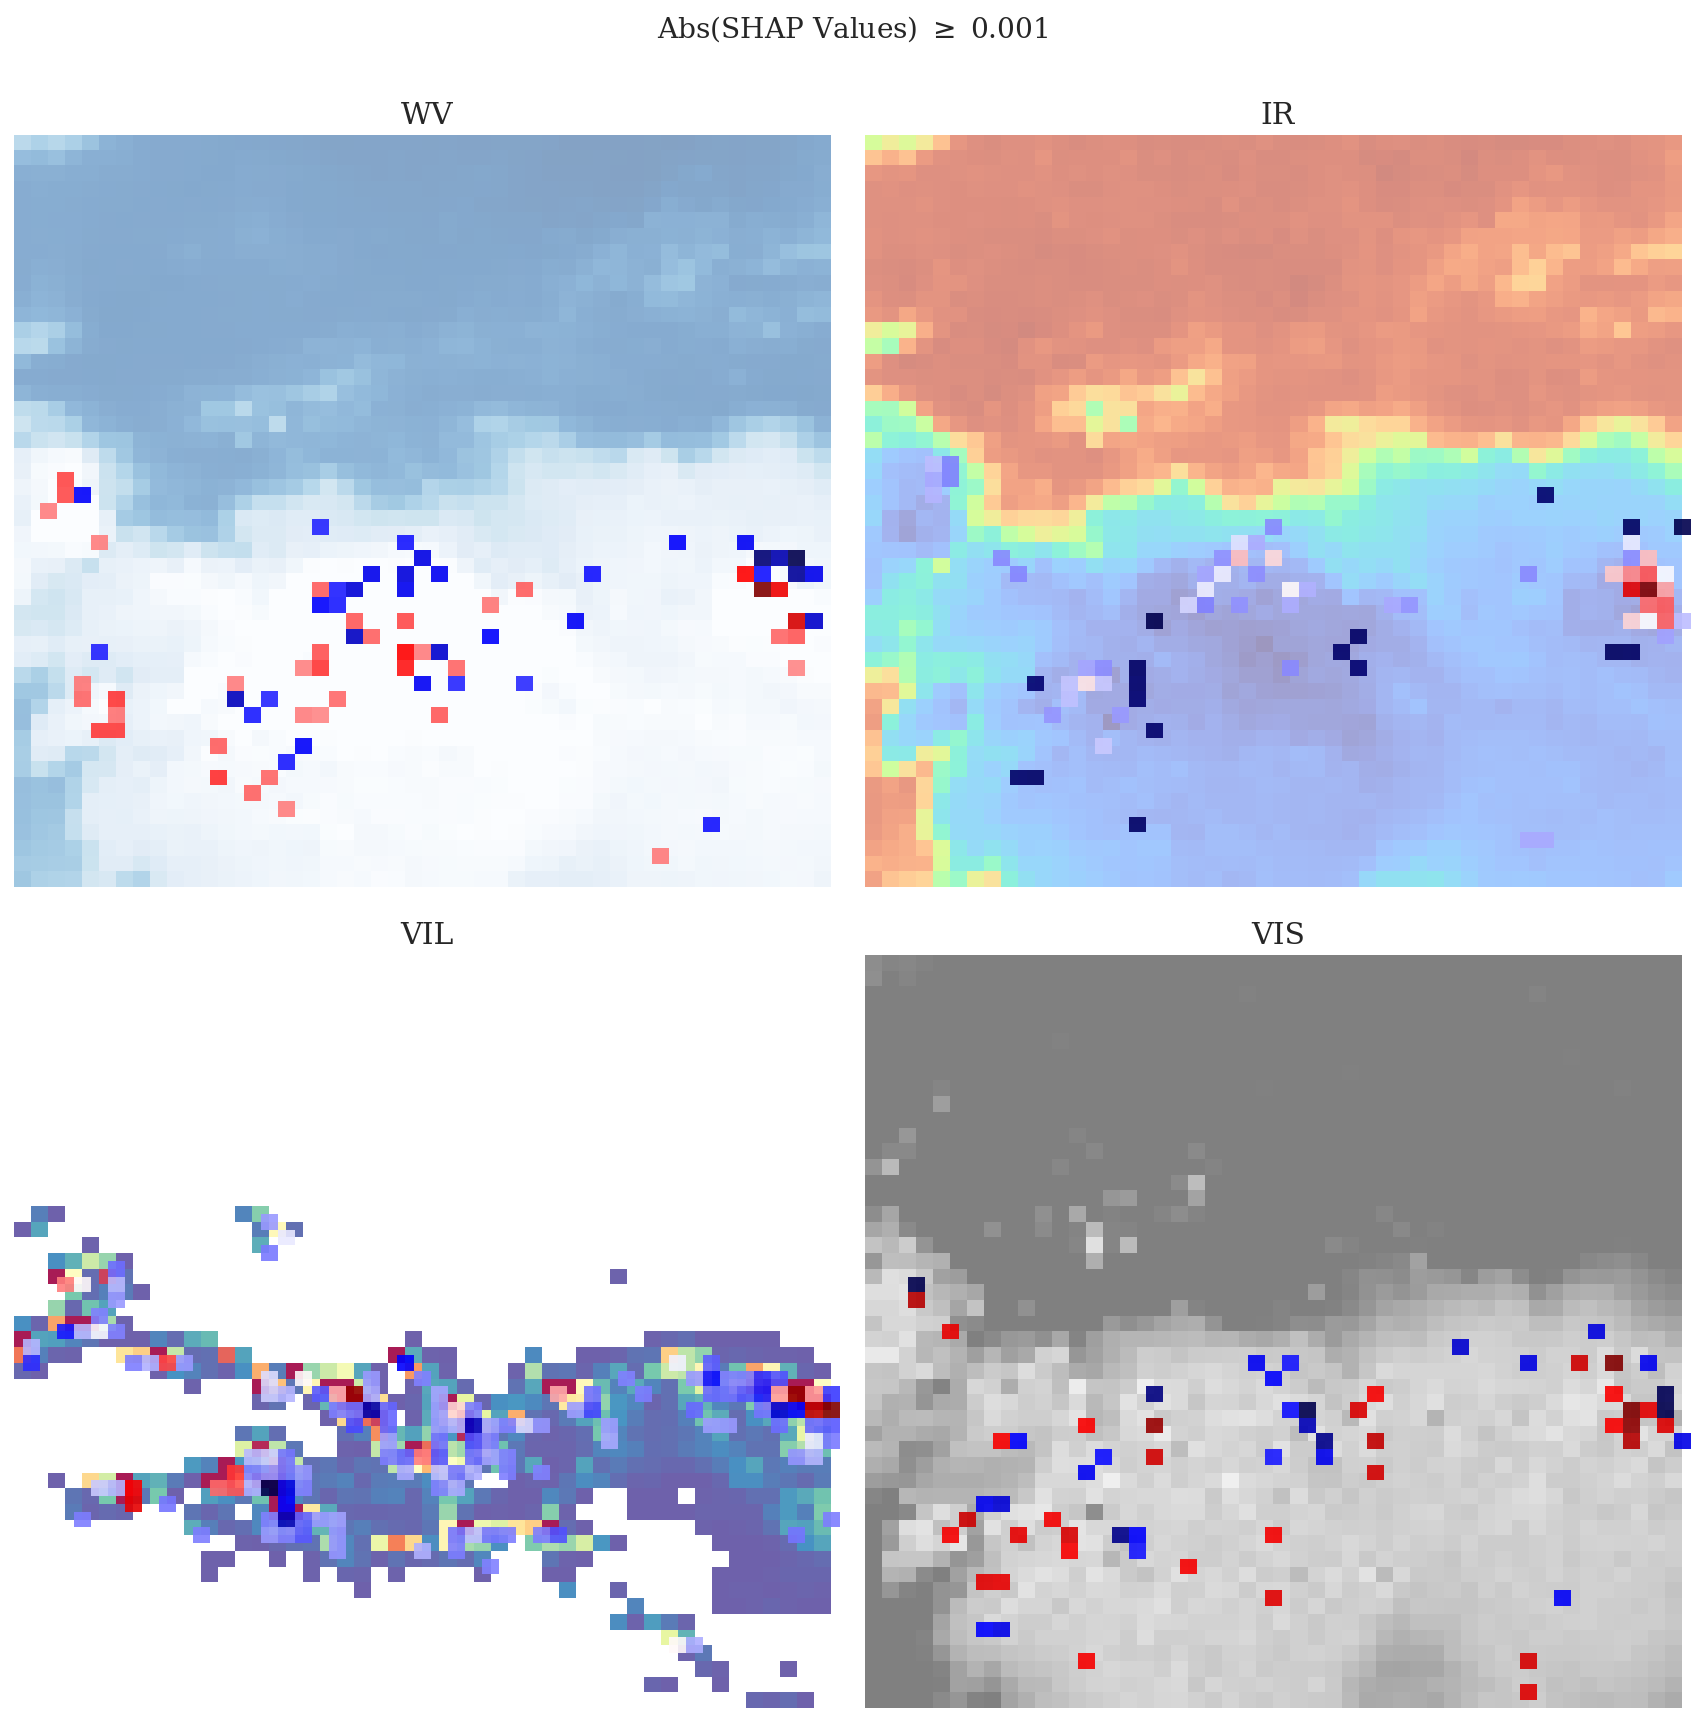

In [119]:
shap_values = class_explainer.shap_values(im[np.newaxis,:,:,:])[0][0]
#shap_values = np.ma.masked_where(np.abs(shap_values)<0.0001, shap_values)

ax = make_plot(im, mask=shap_values)

In [51]:
shap_values.shape

(48, 48, 4)

The `make_plot` function plots the original image on the top row, the shap values for each channel colored on **different** color scales on the middle row, then the last row is the same shap values but all on the **same** colorscale. 

We can see here, that the CNN has learned the boundary of the cloud (panels 1,2 and 4) showing color over the clouded region. While there is not a coherent/simple signal like "all cloud is positive information", it is good to see it is focusing on the cloud to predict if there was lightning in the image. Furthermore, you can see in panel 3, the CNN again has located where the data are, and in general it looks like the higher intensity pixels of VIL are contributing towards lightning being in the image, as expected.

Shap values have a nice property in that the expectation value plus the sum of all shap values provide the CNN output. So another way to visualize shap is to sum all channels together to see what pixels in the image are most important.


<div class="alert alert-block alert-info"><b>Question 1: </b> How would you use this output to explain the model prediction to your specific end-user for the trust-a-thon? How would that change if you were explaining to the other end user for your dataset? </div>

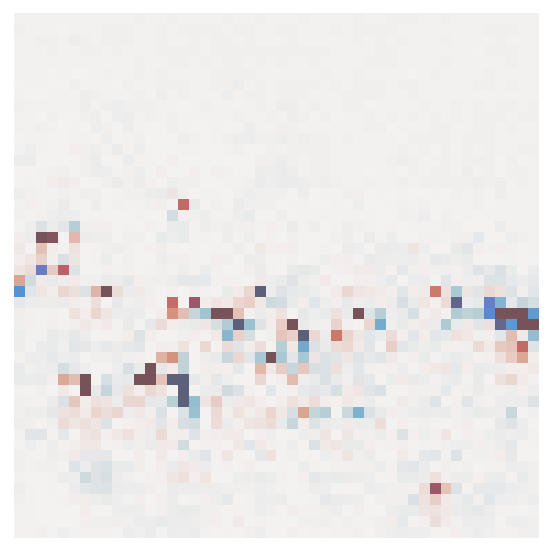

In [9]:
#by default it outputs channelwise results, so here we sum them together
shap_values_summed = np.sum(shap_values,axis=-1)
fig,axes = plt.subplots(1,1,figsize=[4, 4])
fig.set_facecolor('w')
mask = standardanom(shap_values_summed)
axes.imshow(mask,cmap=cmocean.cm.balance,alpha=0.7,vmin=-4,vmax=4)
axes.axis('off')
plt.tight_layout()

It should be clear here that since the summed shap basically outline the VIL, that the VIL seems to be the most important for this one prediction.


Like we mentioned in the previous text box, we can get the CNN output by summing the shap values and adding the expected value. 

In [10]:
shap_values.sum() + class_explainer.expected_value

array([0.99794346], dtype=float32)

Text(0.5, 1.0, 'Shap Image CDF')

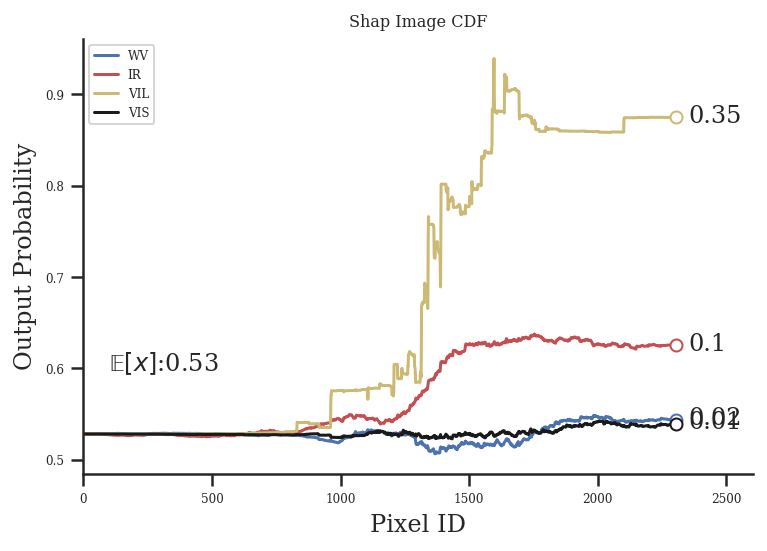

In [11]:
import copy 

fig = plt.figure()
fig.set_facecolor('w')
colors = np.array(['b','r','y','k'])
labels = np.array(['WV','IR','VIL','VIS'])
for i in np.arange(0,4):
    s_tmp = copy.deepcopy(shap_values[:,:,i].ravel())
    idx_to_sort = np.argsort(im[:,:,i].ravel())
    s_tmp = s_tmp.cumsum()
    plt.plot(class_explainer.expected_value + s_tmp,color=colors[i],label=labels[i])
    plt.plot(len(s_tmp),class_explainer.expected_value + s_tmp[-1],'o',
           color=colors[i],markerfacecolor='w')
    anno = str(np.round(s_tmp[-1],2))
    plt.text(len(s_tmp)+50,class_explainer.expected_value + s_tmp[-1]-0.005,
           anno)
  
    anno = '$\mathrm{\mathbb{E}}[x]$:' + str(np.round(class_explainer.expected_value[0],2))

plt.text(100, class_explainer.expected_value[0]+.07,
           anno)
  
plt.legend(loc=2)
plt.ylabel('Output Probability')
plt.xlabel('Pixel ID')
plt.xlim([0,len(s_tmp)+300])
plt.title('Shap Image CDF')

#### ii. Regression

Now we do the same type of analysis for the regression model.

In this example, we compute the CDF of the SHAP values for each feature. The final value is the total contribution from that feature. To re-iterate the expected value (the average model prediction value) plus the SHAP values from each feature equals the model prediction. In this case, the VIL and IR make a large contribution to the model prediction.

\begin{equation}
P = 0.56 + 0.28 + 0.19 + 0.02 - 0.04 \approx 1.0
\end{equation}

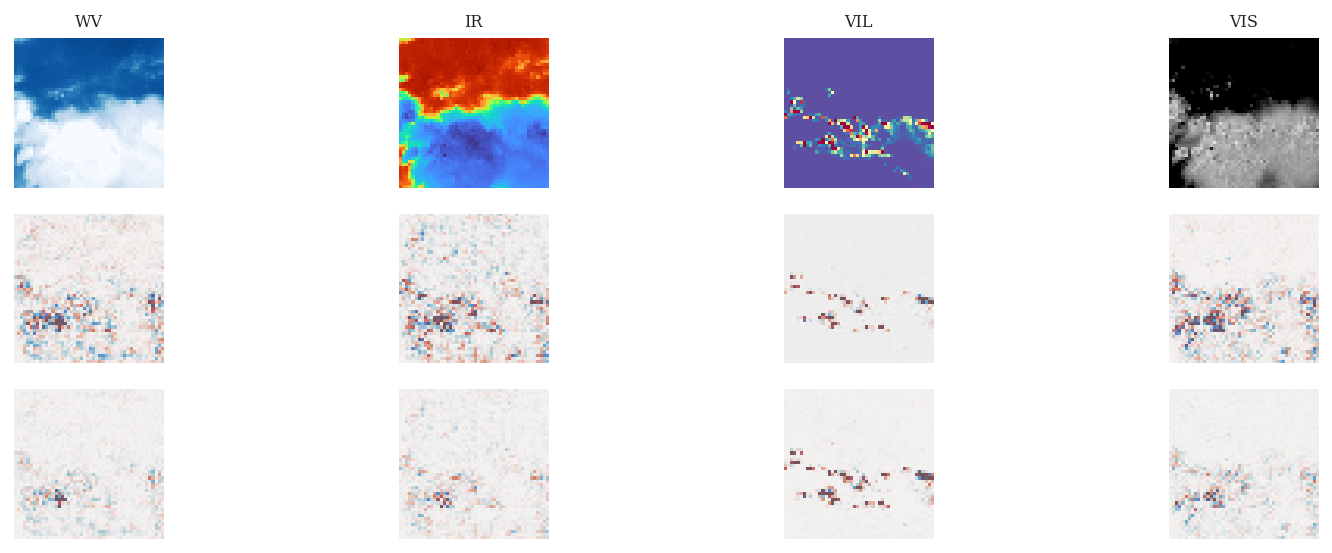

In [12]:
shap_values = reg_explainer.shap_values(im[np.newaxis,:,:,:])[0][0]
ax,m = make_plot(im,mask=shap_values,maskalpha=0.7,title=None)

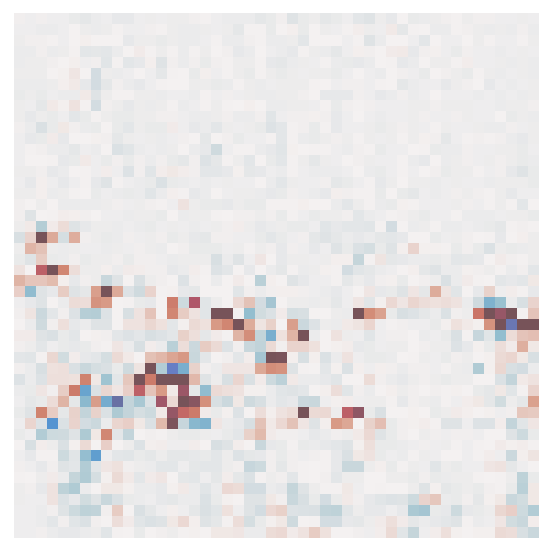

In [13]:
#by default it outputs channelwise results, so here we sum them together
shap_values_summed = np.sum(shap_values,axis=-1)
fig,axes = plt.subplots(1,1,figsize=[4, 4])
fig.set_facecolor('w')
mask = standardanom(shap_values_summed)
axes.imshow(mask,cmap=cmocean.cm.balance,alpha=0.7,vmin=-4,vmax=4)
axes.axis('off')
plt.tight_layout()

The end result is similar, but it is slightly different.

In [14]:
reg_explainer.expected_value + np.sum(shap_values)

array([761.3435], dtype=float32)

#### b. No Storm Example

As a contrasting example, we can consider a satellite image with very little meteorological activity. 

divide by zero encountered in log10


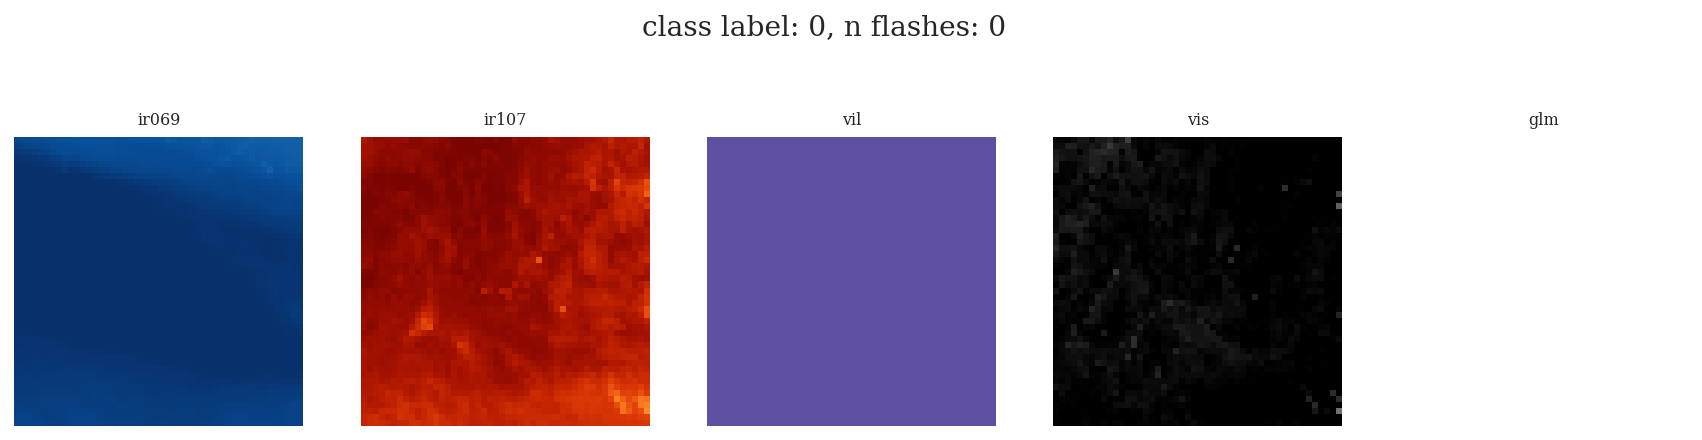

In [15]:
#choose 1 'storm' to show in examples
ds_sample = ds_val.isel(n_samples=ds_val.groupby('id').groups['R19072715377489'])

show_sample(ds_sample.isel(n_samples=0))

#store this image to do the XAI on 
im = ds_sample.isel(n_samples=0).features.values 

##### i. Classification
Below the shap values for the classification model for the no lightning event we chose. This is a confident prediction from the model that there is no lighting, the prediction is effectively 0. 

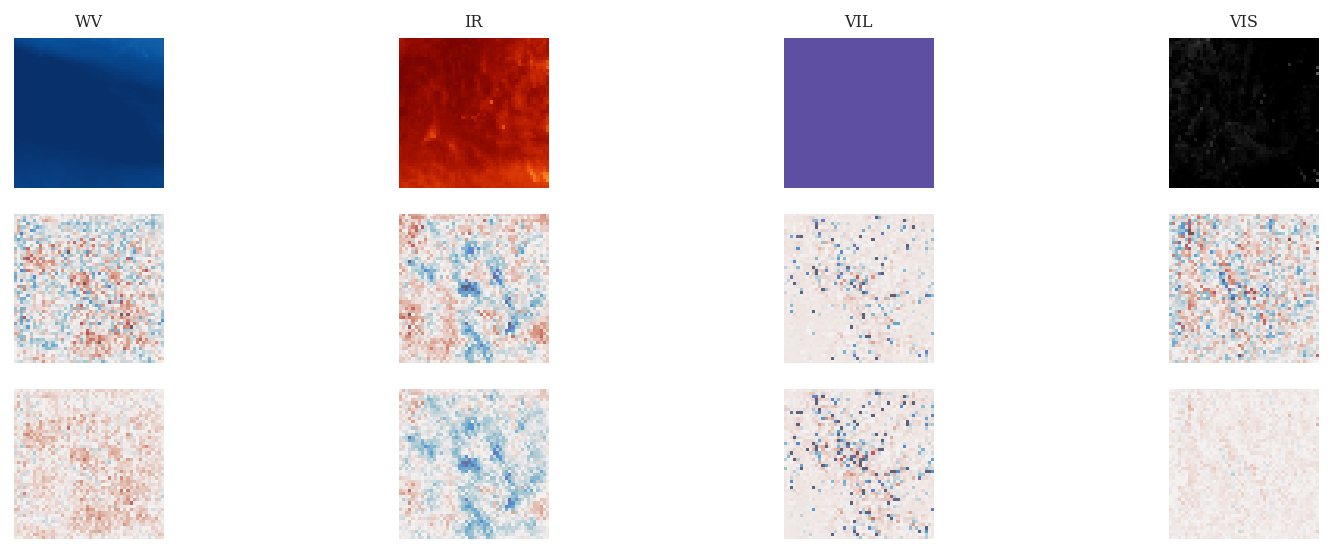

In [16]:
shap_values = class_explainer.shap_values(im[np.newaxis,:,:,:])[0][0]
ax,m = make_plot(im,mask=shap_values,maskalpha=0.7,title=None)

Our interpretation of this is that in general the CNN is not focusing in on any specific region, since there really is nothing in the image to use

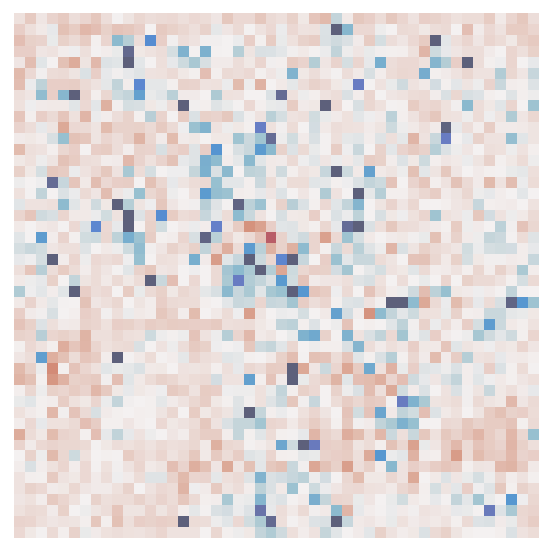

In [17]:
#by default it outputs channelwise results, so here we sum them together
shap_values_summed = np.sum(shap_values,axis=-1)
fig,axes = plt.subplots(1,1,figsize=[4, 4])
fig.set_facecolor('w')
mask = standardanom(shap_values_summed)
axes.imshow(mask,cmap=cmocean.cm.balance,alpha=0.7,vmin=-4,vmax=4)
axes.axis('off')
plt.tight_layout()

In [18]:
class_explainer.expected_value + np.sum(shap_values)

array([0.00637048], dtype=float32)

##### ii. Regression

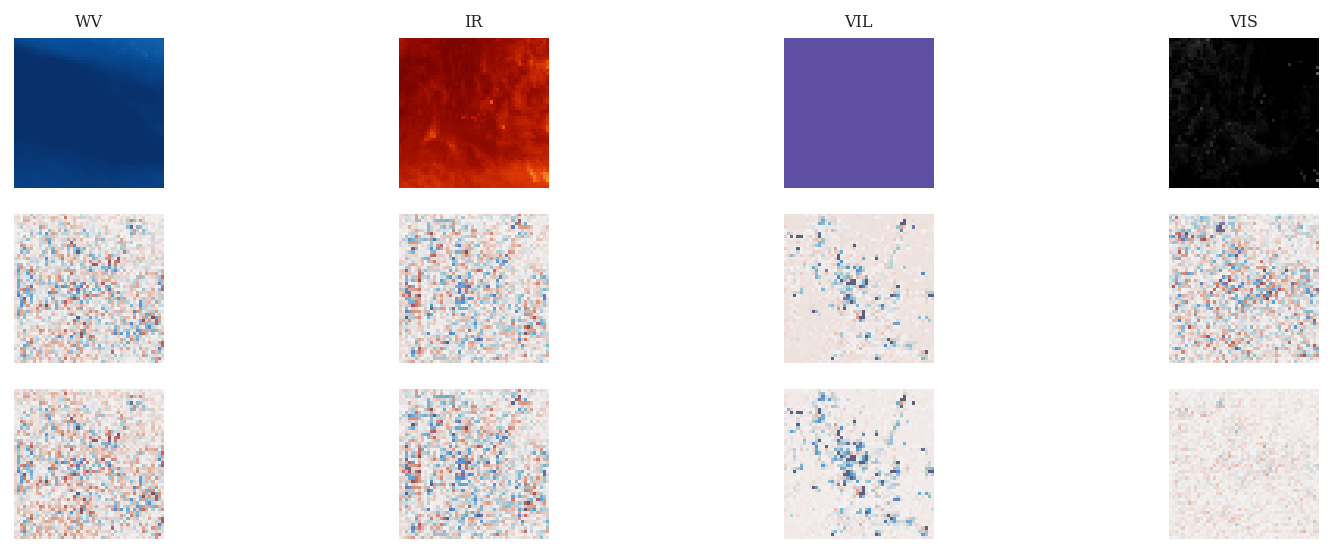

In [19]:
shap_values = reg_explainer.shap_values(im[np.newaxis,:,:,:])[0][0]
ax,m = make_plot(im,mask=shap_values,maskalpha=0.7,title=None)

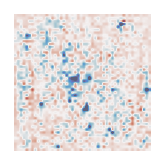

In [20]:
#by default it outputs channelwise results, so here we sum them together
shap_values_summed = np.sum(shap_values,axis=-1)
fig,axes = plt.subplots(1,1,figsize=[1.31, 1.31])
fig.set_facecolor('w')
mask = standardanom(shap_values_summed)
axes.imshow(mask,cmap=cmocean.cm.balance,alpha=0.7,vmin=-4,vmax=4)
axes.axis('off')
  #   # plt.colorbar(pm,ax=ax)
    
  # if title is not None:
  #   fig.suptitle(title,y=1)
plt.tight_layout()

In [21]:
reg_explainer.expected_value + np.sum(shap_values)

array([4.3690186], dtype=float32)

### 6). Summary

In this notebook we showed two case studies *explaining* the deep learning models predictions. One of them was a clear intense storm case with abundant lightning, the other was a cloudy event with no lightning.

### 7). How to select new cases

we only showed two examples above, but there are more than 100,000 images to look at in this dataset. To choose a new example you can look up new storms by index if you want. 

Below is an example of grabing image 42. 

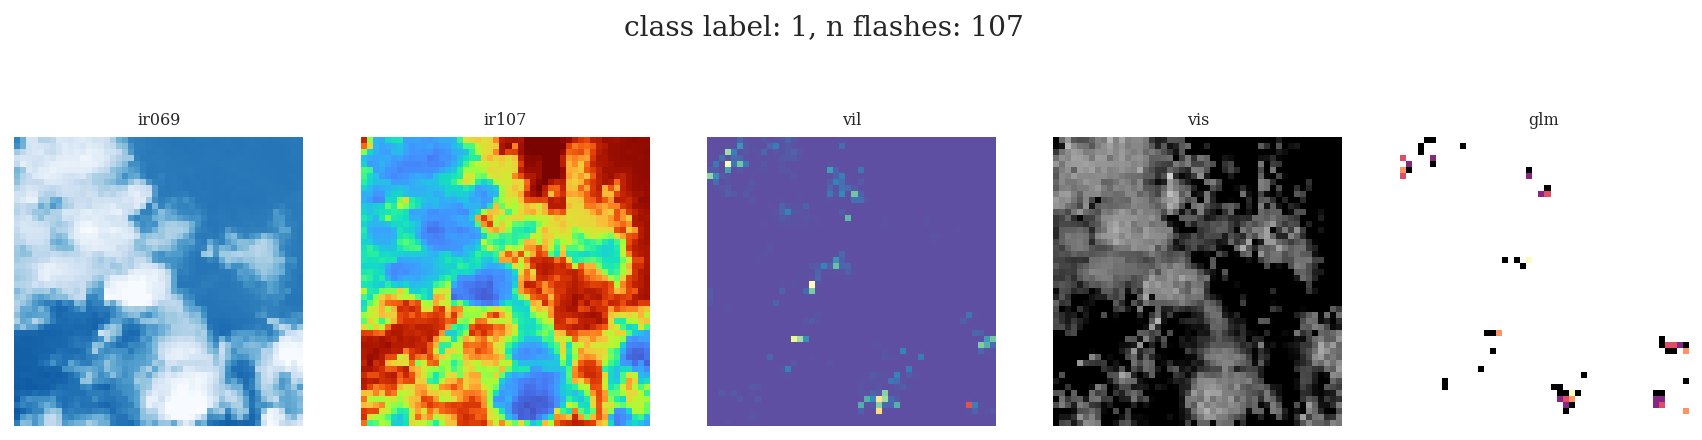

In [22]:
#choose 1 'storm' to show in examples
idx = 42

ds_sample = ds_val.isel(n_samples=idx)

#plot this example with a plotter function I have defined 
show_sample(ds_sample)

#store this image to do the XAI on 
im = ds_sample.features.values 

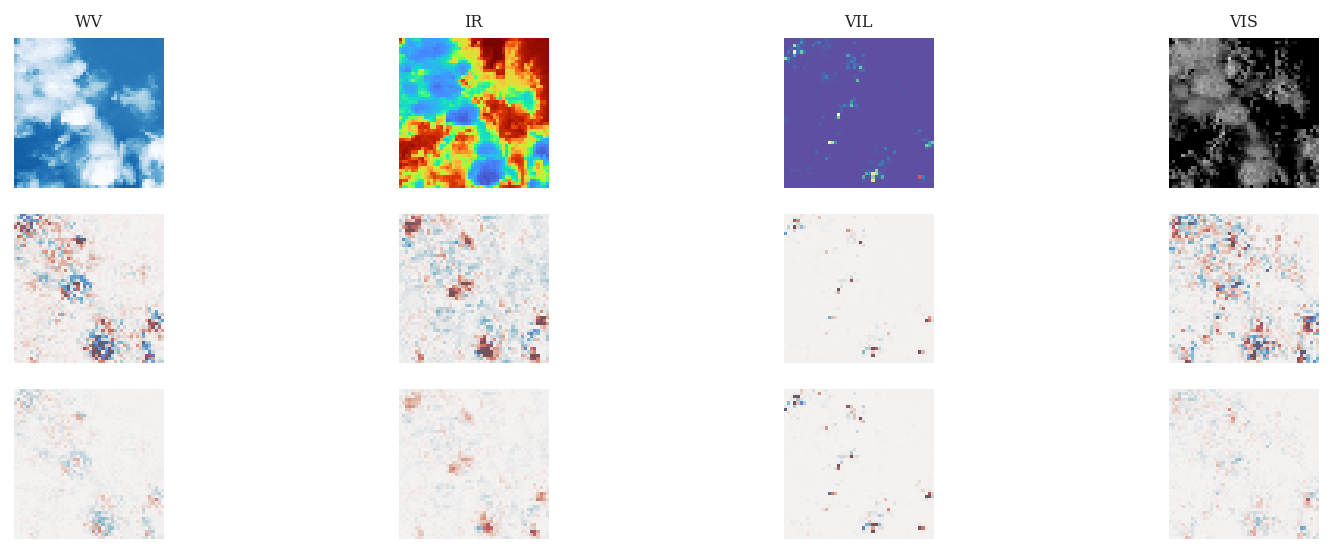

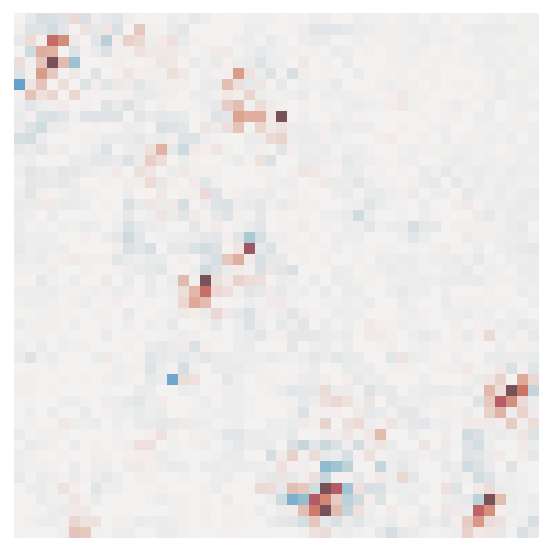

In [23]:
shap_values = class_explainer.shap_values(im[np.newaxis,:,:,:])[0][0]
ax,m = make_plot(im,mask=shap_values)

shap_values_summed = np.sum(shap_values,axis=-1)
fig,axes = plt.subplots(1,1,figsize=[4, 4])
fig.set_facecolor('w')
mask = standardanom(shap_values_summed)
axes.imshow(mask,cmap=cmocean.cm.balance,alpha=0.7,vmin=-4,vmax=4)
axes.axis('off')
plt.tight_layout()

This example it seems to be focusing in on the storm to the bottom of the image, which indeed has lightning

Then what if you wanted a different time step of this same 'storm system'

In [24]:
#choose 1 'storm' to show in examples
ds_sample_all_time = ds_val.isel(n_samples=ds_val.groupby('id').groups[str(ds_sample.id.values)])
ds_sample_all_time

<xarray.Dataset>
Dimensions:         (n_samples: 12, x: 48, y: 48, n_channel: 4)
Coordinates:
    id              (n_samples) object 'R19072723347550' ... 'R19072723347550'
  * n_channel       (n_channel) <U5 'ir069' 'ir107' 'vil' 'vis'
  * n_samples       (n_samples) datetime64[ns] 2019-07-26T23:10:00 ... 2019-0...
Dimensions without coordinates: x, y
Data variables:
    features        (n_samples, x, y, n_channel) float32 ...
    label_1d_class  (n_samples) int8 ...
    label_1d_reg    (n_samples) int16 ...
    label_2d_class  (n_samples, x, y) int8 ...
    label_2d_reg    (n_samples, x, y) int16 ...

You can see now there is 12 samples, which are all the time steps of this one storm scene 

divide by zero encountered in log10


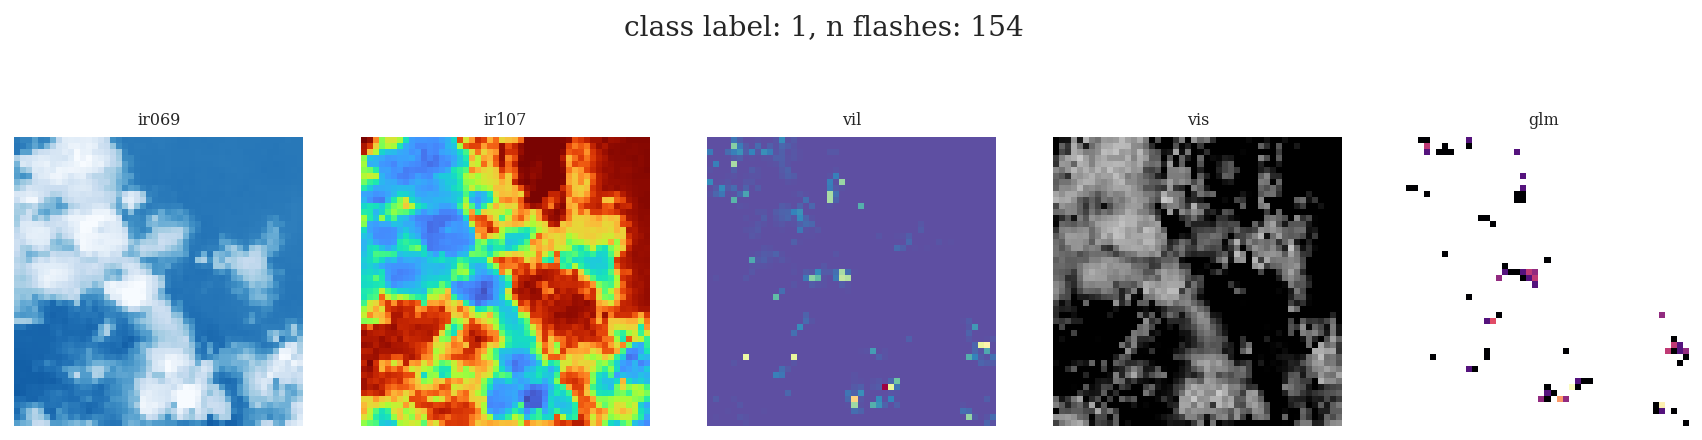

In [25]:
#plot this example with a plotter function I have defined 
show_sample(ds_sample_all_time.isel(n_samples=0))

#store this image to do the XAI on 
im = ds_sample_all_time.isel(n_samples=0).features.values 